# Grouped Simple Moving Average

This notebook compares Temporian's, pandas' and Polars' version of a grouped simple moving average, aiming to evaluate the speed and ease of writing of each library in this specific use case.

## Data

The data we'll be using belongs to the train CSV of [this Kaggle competition](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data?select=train.csv). It contains daily sales records for grocery stores in Ecuador. Each of the 3 million records corresponds to the daily sales of a certain `family` in a certain store number (`store_nbr`).

To run the notebook, download the CSV and place it in `data/train.csv` in the project's root.

Our goal is to calculate the **weekly moving average** of the sales for **each family** in each **store** (i.e., we want the moving average grouped by those two features).

In [1]:
import numpy as np
import pandas as pd
import temporian as tp

Load data to a pandas DataFrame.

In [2]:
sales_df = pd.read_csv('../data/train.csv', parse_dates=['date'])[['date', 'store_nbr', 'sales', 'family']]
sales_df

,date,store_nbr,sales,family
0,2013-01-01,1,0.000,AUTOMOTIVE
1,2013-01-01,1,0.000,BABY CARE
2,2013-01-01,1,0.000,BEAUTY
3,2013-01-01,1,0.000,BEVERAGES
4,2013-01-01,1,0.000,BOOKS
...,...,...,...,...
3000883,2017-08-15,9,438.133,POULTRY
3000884,2017-08-15,9,154.553,PREPARED FOODS
3000885,2017-08-15,9,2419.729,PRODUCE
3000886,2017-08-15,9,121.000,SCHOOL AND OFFICE SUPPLIES


Load data to a Temporian EventSet.

In [3]:
sales_evset = tp.from_csv('../data/train.csv', timestamps='date')[['sales', 'store_nbr', 'family']]
sales_evset

timestamp,sales,store_nbr,family
2013-01-01 00:00:00+00:00,0,1,AUTOMOTIVE
2013-01-01 00:00:00+00:00,0,1,BABY CARE
2013-01-01 00:00:00+00:00,0,1,BEAUTY
2013-01-01 00:00:00+00:00,0,1,BEVERAGES
2013-01-01 00:00:00+00:00,0,1,BOOKS
…,…,…,…


## Grouped moving average in pandas

We use the `rolling` method of pandas DataFrames to calculate the moving average. We group by `store_nbr` and `family` and then apply the rolling method to the `sales` column.

We'll only measure the time it takes to compute the actual moving average, not the time it takes to group the data, since it is not directly comparable between the two libraries.

In [4]:
grouped_df = sales_df.groupby(['store_nbr', 'family'])

In [5]:
%%timeit -o

grouped_df.rolling('7d', on='date').mean()

811 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 811 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [6]:
pd_res = _

## Grouped moving average in Temporian

Temporian can handle grouped (or hierarchically structured) data natively, using [indexes](https://temporian.readthedocs.io/en/stable/user_guide/#indexes-horizontal-and-vertical-operators). Once our data has the correct index, applying a `simple_moving_average` to it is straightforward.

In [7]:
grouped_evset = sales_evset.add_index(['store_nbr', 'family'])

In [8]:
%%timeit -o

grouped_evset.simple_moving_average(tp.duration.weeks(1))

25.6 ms ± 161 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 25.6 ms ± 161 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [9]:
tp_res = _

## Results

Computing the same grouped moving average in Temporian resulted in a **30x speedup** in this dataset!

#### Sanity check

As a sanity check, lets make sure the results from both libraries are the same.

In [10]:
# Run them again since %%timeit doesn't modify vars in the outer scope
pd_result = grouped_df.rolling('7d', on='date').mean()
tp_result = grouped_evset.simple_moving_average(tp.duration.weeks(1))

tp_sma = tp.to_pandas(tp_result).sort_values(['store_nbr', 'family', 'timestamp'])['sales']
pd_sma = pd_result.sort_values(['store_nbr', 'family', 'date'])['sales']
np.allclose(pd_sma, tp_sma)

True

## But... what about Polars?

[Polars](https://www.pola.rs/) is a DataFrame library written in Rust, born as a performance-oriented alternative to pandas. Lets see how it fares on this same task!

In [11]:
import polars as pl

polars_df = pl.read_csv("../data/train.csv", try_parse_dates=True, columns=['date', 'store_nbr', 'sales', 'family'])
polars_df.head()

date,store_nbr,family,sales
date,i64,str,f64
2013-01-01,1,"""AUTOMOTIVE""",0.0
2013-01-01,1,"""BABY CARE""",0.0
2013-01-01,1,"""BEAUTY""",0.0
2013-01-01,1,"""BEVERAGES""",0.0
2013-01-01,1,"""BOOKS""",0.0


In [12]:
%%time

pl_result = polars_df.rolling(index_column='date', by=['store_nbr', 'family'], period='7d', offset='-7d').agg(pl.col('sales').mean())

CPU times: user 832 ms, sys: 160 ms, total: 992 ms
Wall time: 239 ms


### Results

Polars didn't get an edge over pandas - and Temporian is still **37x** faster than it.

Note that this comparison isn't exactly fair though, since Polars doesn't provide a way to apply `.rolling()` over an already grouped DataFrame, which means we're counting both the grouping and the rolling average in the result!

Lets do the same sanity check as before.

In [13]:
pl_sma = pl_result.to_pandas().sort_values(['store_nbr', 'family', 'date'])['sales']
np.allclose(pd_sma, pl_sma)

True

# How does this scale?

3 million records is already a decent dataset - but we might just find that scaling it up to larger amounts of data makes Temporian an even more attractive choie.

Lets see how each library's performance scales to **5x** and **20x** the original number of rows!

### Pandas

In [14]:
sales_df_5x = pd.concat([sales_df] * 5).sort_values(['date']).reset_index(drop=True)
grouped_df_5x = sales_df_5x.groupby(['store_nbr', 'family'])

sales_df_20x = pd.concat([sales_df] * 20).sort_values(['date']).reset_index(drop=True)
grouped_df_20x = sales_df_20x.groupby(['store_nbr', 'family'])

sales_df_100x = pd.concat([sales_df] * 100).sort_values(['date']).reset_index(drop=True)
grouped_df_100x = sales_df_100x.groupby(['store_nbr', 'family'])

In [15]:
%%timeit -o -n1 -r1

grouped_df_5x.rolling('7d', on='date').mean()

5.47 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 5.47 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [16]:
pd_res_5x = _

In [17]:
%%timeit -o -n1 -r1

grouped_df_20x.rolling('7d', on='date').mean()

24.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 24.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [18]:
pd_res_20x = _

In [19]:
%%timeit -o -n1 -r1

grouped_df_100x.rolling('7d', on='date').mean()

2min 23s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 2min 23s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [20]:
pd_res_100x = _

### Temporian

In [21]:
grouped_evset_5x = tp.combine(*([grouped_evset] * 5))  # No need to sort values nor group again - Temporian natively stores data ordered by timestamp and grouped by index
grouped_evset_20x = tp.combine(*([grouped_evset_5x] * 4))
grouped_evset_100x = tp.combine(*([grouped_evset_20x] * 5))

In [22]:
%%timeit -o

grouped_evset_5x.simple_moving_average(tp.duration.weeks(1))

78.3 ms ± 968 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 78.3 ms ± 968 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [23]:
tp_res_5x = _

In [24]:
%%timeit -o

grouped_evset_20x.simple_moving_average(tp.duration.weeks(1))

254 ms ± 1.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 254 ms ± 1.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [25]:
tp_res_20x = _

In [26]:
%%timeit -o

grouped_evset_100x.simple_moving_average(tp.duration.weeks(1))

1.23 s ± 4.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 1.23 s ± 4.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [27]:
tp_res_100x = _

# Results

Temporian is **70x**, **95x** and **120x** faster than pandas for 5M, 15M and 60M records respectively! Although both grow linearly with the number of records, Temporian does so at a much slower rate.

We can visualize how differently the performance of each library degrades as the number of records increases by plotting the results.

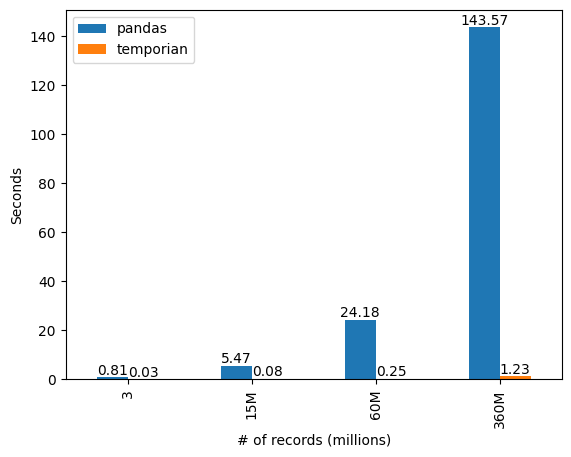

In [28]:
avg = lambda result: round(result.average, 2)

data = pd.DataFrame({
    "pandas": [avg(pd_res), avg(pd_res_5x), avg(pd_res_20x), avg(pd_res_100x)],
    "temporian": [avg(tp_res), avg(tp_res_5x), avg(tp_res_20x), avg(tp_res_100x)],
}, index=['3', '15M', '60M', '360M'])
ax = data.plot.bar(xlabel='# of records (millions)', ylabel='Seconds')

for container in ax.containers:
    ax.bar_label(container)

<Axes: xlabel='# of records (millions)', ylabel='Times faster than pandas'>

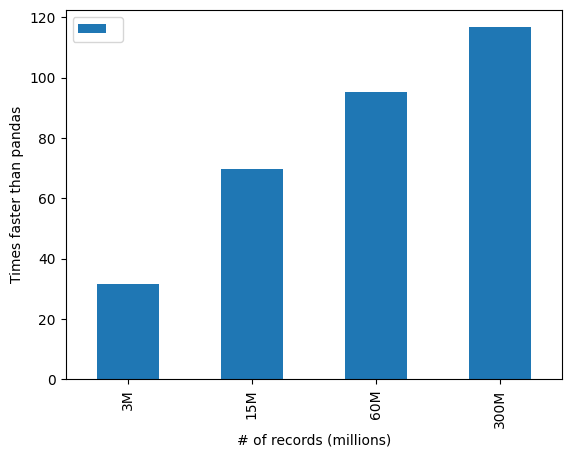

In [29]:
data = pd.DataFrame({
    "": [pd_res.average/tp_res.average, pd_res_5x.average/tp_res_5x.average, pd_res_20x.average/tp_res_20x.average, pd_res_100x.average/tp_res_100x.average],
}, index=['3M', '15M', '60M', '300M'])
data.plot.bar(xlabel='# of records (millions)', ylabel='Times faster than pandas')